<a href="https://colab.research.google.com/github/Justinmchan408/RNAModificationDetectionNanoporeSeq/blob/main/DetectingRNAMods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

# Load the data - If using Google drive link to access data the following with connect
# to drive, authenticate using your Google account and load the data

!pip install -U -q PyDrive ## you will have install for every colab session

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Direct RNA (GM12878): https://drive.google.com/file/d/1KTfPsAbLvzlC-Wv3DatTPWJo7uhVEDPT/view?usp=sharing
# IVT Data: https://drive.google.com/file/d/1u-om1NRtcCOTzHQISc03wx7gS909d456/view?usp=sharing
# PsuedoUPositions: https://drive.google.com/file/d/1Vv_4vVI3a5w0-AEymiUyFB9JIk13Y0mQ/view?usp=sharing
# ALL PsuedoUPositions: https://drive.google.com/file/d/1Eswfw-6nemFeOFoSr7SOn5RmsKhBHfYq/view?usp=sharing


# 2. Now proxy the Google Drive files to a local file
directRNAimport = drive.CreateFile({'id':'1KTfPsAbLvzlC-Wv3DatTPWJo7uhVEDPT'})
IVTimport = drive.CreateFile({'id':'1u-om1NRtcCOTzHQISc03wx7gS909d456'})
pseudoUposimport = drive.CreateFile({'id':'1Vv_4vVI3a5w0-AEymiUyFB9JIk13Y0mQ'})
ALLpseudoUposimport = drive.CreateFile({'id':'1Eswfw-6nemFeOFoSr7SOn5RmsKhBHfYq'})

directRNAimport.GetContentFile('reads-ref.eventalign.txt') # reads-ref.eventalign.txt is the file name that will be accessible in the notebook.
IVTimport.GetContentFile('reads-ref.NewIVT.eventalign.txt') # reads-ref.NewIVT.eventalign.txt is the file name that will be accessible in the notebook.
pseudoUposimport.GetContentFile('pseudoUpositions.txt')
ALLpseudoUposimport.GetContentFile('allMotifpseudoUpositions.txt')

In [ ]:
import pandas as pd
import numpy as np

# Creates a dataframe with the direct RNA dataset
dfDirect = pd.read_csv("reads-ref.eventalign.txt", delimiter= "\t")
dfDirect.head(5)

,contig,position,reference_kmer,read_index,strand,event_index,event_level_mean,event_stdv,event_length,model_kmer,model_mean,model_stdv,standardized_level
0,chr1,14360,ATCCT,0.0,t,2998.0,116.55,4.483,0.00398,AGGAT,120.37,3.17,-1.01
1,chr1,14361,TCCTG,0.0,t,2997.0,89.45,5.927,0.00896,CAGGA,98.38,7.84,-0.96
2,chr1,14362,CCTGC,0.0,t,2996.0,82.43,5.103,0.00598,GCAGG,87.86,5.09,-0.90
3,chr1,14363,CTGCA,0.0,t,2995.0,104.31,4.296,0.00631,TGCAG,103.32,3.86,0.22
4,chr1,14363,CTGCA,0.0,t,2994.0,102.91,2.903,0.00398,TGCAG,103.32,3.86,-0.09


In [ ]:
# Creates a dataframe with the IVT dataset
dfIVT = pd.read_csv("reads-ref.NewIVT.eventalign.txt", delimiter= "\t")
dfIVT.head(5)

,contig,position,reference_kmer,read_index,strand,event_index,event_level_mean,event_stdv,event_length,model_kmer,model_mean,model_stdv,standardized_level
0,chr1,14404,TTCTG,0,t,3000,107.81,2.073,0.03320,CAGAA,108.60,5.87,-0.12
1,chr1,14404,TTCTG,0,t,2999,105.47,1.492,0.00598,CAGAA,108.60,5.87,-0.47
2,chr1,14405,TCTGC,0,t,2998,104.21,2.624,0.01527,GCAGA,99.93,5.09,0.74
3,chr1,14405,TCTGC,0,t,2997,87.08,2.809,0.00432,GCAGA,99.93,5.09,-2.22
4,chr1,14405,TCTGC,0,t,2996,82.64,2.308,0.00266,GCAGA,99.93,5.09,-2.98


In [ ]:
# Prints size of both datasets:
# Direct RNA
# IVT
print(dfDirect.index)
print(dfIVT.index)

RangeIndex(start=0, stop=1693024, step=1)
RangeIndex(start=0, stop=1611182, step=1)


In [ ]:
# Shrink the dataset to the first 100000 points/datapoints
dfDirect = dfDirect.iloc[:100000]
dfIVT = dfIVT.iloc[:100000]
'''
indexDirectNames = dfDirect[dfDirect['model_mean'] == 0.00].index
indexIVTNames = dfIVT[dfIVT['model_mean'] == 0.00].index

dfDirect.drop(indexDirectNames, inplace = True)
dfIVT.drop(indexIVTNames, inplace = True)
'''
# Check size
print(dfDirect.index)
print(dfIVT.index)

RangeIndex(start=0, stop=100000, step=1)
RangeIndex(start=0, stop=100000, step=1)


In [ ]:
# Creating a 5-mer dictionaries for Direct RNA and IVT data with event_level_mean (current levels)
import itertools

rnaMotifDict = {'NaN': []}
ivtDict = {'NaN': []}

a = "ATGC"
for eachMotif in itertools.product(a, repeat = 5):
    rnaMotifDict[''.join(eachMotif)] = []
    ivtDict[''.join(eachMotif)] = []

for index in range(len(dfDirect)):
    if isinstance(dfDirect['reference_kmer'][index], str) and len(dfDirect['reference_kmer'][index]) == 5 and dfDirect['model_mean'][index] != 0.00:
        rnaMotifDict[dfDirect['reference_kmer'][index]].append(dfDirect['event_level_mean'][index])
    if isinstance(dfIVT['reference_kmer'][index], str) and len(dfIVT['reference_kmer'][index]) == 5 and dfIVT['model_mean'][index] != 0.00:
        ivtDict[dfIVT['reference_kmer'][index]].append(dfIVT['event_level_mean'][index])

print("Direct RNA current values:")
print(rnaMotifDict)
print("IVT current values:")
print(ivtDict)

Direct RNA current values:
{'NaN': [], 'AAAAA': [81.46, 82.76, 80.89, 83.93, 80.04, 82.04, 80.5, 79.47, 84.01, 79.0, 80.14, 79.25, 80.51, 78.65, 78.47, 81.6, 80.25, 81.18, 80.21, 80.4, 85.67, 79.73, 80.66, 83.88, 82.81, 79.72, 80.47, 82.34, 79.45, 81.92, 81.31, 80.74], 'AAAAT': [81.52, 81.5, 82.67, 81.55, 82.06, 83.02, 81.99, 83.19, 83.9, 81.1, 82.89, 82.3, 78.68, 85.18, 82.27, 81.88, 83.85, 82.04, 76.52, 81.35, 82.78, 81.63, 79.45, 81.93, 81.23, 81.92, 82.32, 83.91, 84.73, 85.01, 81.71, 81.67, 82.93, 83.06, 82.05, 85.93, 82.37, 80.74, 76.67], 'AAAAG': [82.7, 80.96, 79.13, 78.0, 80.27, 80.31, 84.41, 80.6, 81.08, 81.99, 80.16, 78.13, 79.56, 81.3, 82.48, 81.26, 81.16, 81.83, 79.41, 77.23, 82.1, 79.28, 80.98, 77.17, 76.18, 79.3, 79.02, 79.37, 77.11, 78.04, 76.1, 76.19, 77.74, 79.14, 77.54, 76.73, 78.27, 79.38, 76.11, 79.19, 76.12, 76.66, 77.57, 77.03, 79.99, 76.89, 82.14, 77.74, 77.46, 77.11, 78.3], 'AAAAC': [80.58, 75.91, 81.69, 74.48, 75.44, 77.41, 80.94, 79.84, 78.39, 74.75, 77.68, 78.

In [ ]:
# Let us see which 5-mer from the direct RNA data has the greatest amount of data by ordering them
motifData = []
motifDataDictionary = dict()
for eachMotif, currentVals in rnaMotifDict.items():
    motifData.append([eachMotif, len(currentVals)])
    motifDataDictionary[eachMotif] = len(currentVals)
motifData.sort(key = lambda x: x[1], reverse=True)
print(motifData)

[['TGCTC', 2264], ['CCCAG', 1775], ['TGGAG', 1014], ['GTCCT', 988], ['GTGTG', 945], ['GCTGG', 821], ['CCAGC', 806], ['GCCCC', 803], ['GAGCC', 794], ['GGTGG', 753], ['GTCAT', 735], ['GCAGA', 681], ['CAGAG', 679], ['CAGTG', 671], ['CACAG', 665], ['CCCCT', 665], ['GTGGC', 661], ['TTCCC', 660], ['GGTTC', 653], ['CTCCT', 648], ['CTGGG', 646], ['GCTCC', 617], ['TCGTC', 575], ['ACAGA', 572], ['GTTTT', 567], ['CAGCT', 560], ['GAGCA', 556], ['AGGCT', 527], ['TCAGA', 512], ['CCGTC', 502], ['CCTCT', 498], ['TGGTT', 496], ['CCTCA', 492], ['GTCTG', 486], ['CATGG', 482], ['TGCTG', 475], ['CGTCC', 472], ['CTGCT', 467], ['GGAGC', 449], ['GGTCT', 446], ['GGCTG', 440], ['CCCCC', 440], ['TCTGG', 438], ['GGAAG', 432], ['TGGGT', 420], ['CCTCC', 418], ['GGTGT', 410], ['TTTTC', 401], ['CAGAC', 397], ['CAGAA', 391], ['AAGAA', 388], ['GGCAG', 388], ['TCCGG', 385], ['CTGGT', 382], ['CCGTT', 378], ['CCCAA', 377], ['AGCTG', 376], ['CGGGC', 376], ['TATTG', 374], ['TCCCA', 374], ['AAGCC', 370], ['GAAGT', 370], ['CT

In [ ]:
# Create KMeans model
from sklearn.cluster import KMeans

km = KMeans(n_clusters = 2)
exampleNumpy = np.asarray(rnaMotifDict.get("TGCTC")).reshape(-1,1)
y_predicted = km.fit_predict(exampleNumpy)
print(y_predicted)

[1 1 1 ... 1 1 1]


[10213.877872393992, 4707.324683585233, 2645.111094025927, 1618.9323523434655, 1080.4277539414081, 793.8135365573773, 611.238036204191, 483.90944228481226, 376.5054538577783]


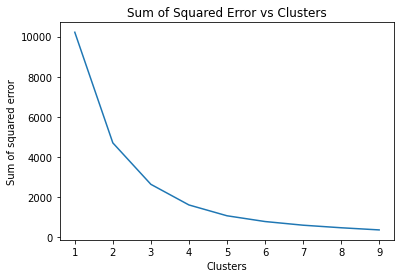

In [ ]:
# Create Sum of Squared Error graph to find clusters that should be used
import matplotlib.pyplot as plt
sse = []
for k in range(1, 10):
    km = KMeans(n_clusters = k)
    km.fit(exampleNumpy)
    sse.append(km.inertia_)

print(sse)
plt.title('Sum of Squared Error vs Clusters')
plt.xlabel('Clusters')
plt.ylabel('Sum of squared error')
plt.plot(range(1,10), sse)
plt.show()

In [ ]:
dfMotifAAAAA = dfDirect[dfDirect['reference_kmer'] == 'AAAAA']
dfMotifAAAAA = dfMotifAAAAA[dfMotifAAAAA['model_kmer'] != 'NNNNN']
# Create Cluster Model, KMeans with AAAAA motif
km = KMeans(n_clusters = 2)
dfMotifAAAAA["cluster"] = km.fit_predict(dfMotifAAAAA[['event_level_mean']])
dfMotifAAAAA.head(len(dfMotifAAAAA))

,contig,position,reference_kmer,read_index,strand,event_index,event_level_mean,event_stdv,event_length,model_kmer,model_mean,model_stdv,standardized_level,cluster
12480,chr1,14908,AAAAA,13.0,t,7800.0,81.46,1.280,0.00232,TTTTT,80.78,1.97,0.28,0
14069,chr1,15468,AAAAA,13.0,t,6211.0,82.76,0.920,0.00299,TTTTT,80.78,1.97,0.82,1
14070,chr1,15468,AAAAA,13.0,t,6210.0,80.89,0.941,0.00598,TTTTT,80.78,1.97,0.05,0
15943,chr1,16318,AAAAA,13.0,t,4337.0,83.93,1.068,0.00863,TTTTT,80.78,1.97,1.31,1
16254,chr1,16505,AAAAA,13.0,t,4026.0,80.04,1.008,0.00963,TTTTT,80.78,1.97,-0.31,0
16255,chr1,16505,AAAAA,13.0,t,4025.0,82.04,0.539,0.00232,TTTTT,80.78,1.97,0.52,1
16256,chr1,16506,AAAAA,13.0,t,4024.0,80.50,1.080,0.00664,TTTTT,80.78,1.97,-0.12,0
35184,chr1,14908,AAAAA,33.0,t,2749.0,79.47,1.177,0.00797,TTTTT,80.78,1.97,-0.54,0
36262,chr1,15468,AAAAA,33.0,t,1671.0,84.01,1.538,0.00365,TTTTT,80.78,1.97,1.33,1
43211,chr1,14908,AAAAA,40.0,t,6581.0,79.00,1.120,0.00996,TTTTT,80.78,1.97,-0.63,0


In [ ]:
# Create Classification method, Logistic Regression

listOfClusterVals = list(dfMotifAAAAA['cluster'])
actualIVTVal = max(listOfClusterVals, key = listOfClusterVals.count)

from sklearn import preprocessing, datasets, linear_model
logModel = linear_model.LogisticRegression(solver = "liblinear", class_weight = "balanced")
logModel.fit(dfMotifAAAAA[['event_level_mean']], dfMotifAAAAA['cluster'])

dfIVTMotifAAAAA = dfIVT[dfIVT['reference_kmer'] == 'AAAAA']
dfIVTMotifAAAAA.head(len(dfIVTMotifAAAAA))

,contig,position,reference_kmer,read_index,strand,event_index,event_level_mean,event_stdv,event_length,model_kmer,model_mean,model_stdv,standardized_level
8926,chr1,16318,AAAAA,7,t,2359,79.55,1.227,0.01096,TTTTT,80.78,1.97,-0.56
9390,chr1,16505,AAAAA,7,t,1895,80.07,0.686,0.00797,TTTTT,80.78,1.97,-0.32
9391,chr1,16506,AAAAA,7,t,1894,81.08,1.201,0.00432,TTTTT,80.78,1.97,0.14
18306,chr1,134798,AAAAA,18,t,294,78.02,1.290,0.00332,TTTTT,80.78,1.97,-1.24
19967,chr1,134798,AAAAA,19,t,1060,77.86,1.697,0.00697,TTTTT,80.78,1.97,-1.36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
97715,chr1,629346,AAAAA,82,t,535,111.52,1.541,0.00232,AAAAA,108.90,2.68,0.81
98347,chr1,629345,AAAAA,83,t,515,115.56,7.853,0.00797,AAAAA,108.90,2.68,2.14
98348,chr1,629346,AAAAA,83,t,516,106.09,3.037,0.01029,AAAAA,108.90,2.68,-0.90
99592,chr1,629345,AAAAA,85,t,697,106.98,4.879,0.02125,AAAAA,108.90,2.68,-0.62


In [ ]:
predictedVals = list(logModel.predict(dfIVTMotifAAAAA[['event_level_mean']]))
print("Accuracy: " + str(predictedVals.count(actualIVTVal)/len(predictedVals)))

Accuracy: 0.009174311926605505


In [ ]:
# Method for creating clustering/classification for each kmer

def kmerPredictionAccuracy(directRNADataFrame, ivtDataFrame):
    motifAccuracyModelDict = {}
    a = "ATGC"
    for eachMotif in itertools.product(a, repeat = 5):
        currentMotif = ''.join(eachMotif)
        dfDirectMotif = directRNADataFrame.loc[directRNADataFrame['reference_kmer'] == currentMotif]
        dfIVTMotif = ivtDataFrame.loc[ivtDataFrame['reference_kmer'] == currentMotif]
        
        if len(dfDirectMotif) > 1 and len(dfIVTMotif) > 1:
            km = KMeans(n_clusters = 2)
            dfDirectMotif["cluster"] = km.fit_predict(dfDirectMotif[['event_level_mean']])

            listOfClusterVals = list(dfDirectMotif['cluster'])
            actualIVTVal = max(listOfClusterVals, key = listOfClusterVals.count)

            logModel = linear_model.LogisticRegression(solver = "liblinear", class_weight = "balanced")
            logModel.fit(dfDirectMotif[['event_level_mean']], dfDirectMotif['cluster'])

            predictedVals = list(logModel.predict(dfIVTMotif[['event_level_mean']]))
            motifAccuracyModelDict[currentMotif] = predictedVals.count(actualIVTVal)/len(predictedVals)
        else:
            motifAccuracyModelDict[currentMotif] = -1
    return motifAccuracyModelDict


In [ ]:
from statistics import mean
pd.options.mode.chained_assignment = None # To not get warning message

accuracyDict = kmerPredictionAccuracy(dfDirect, dfIVT)
print(accuracyDict)
dataModelAccuracies = [val for val in accuracyDict.values() if val >= 0]
print(mean(dataModelAccuracies))

{'AAAAA': 0.5504587155963303, 'AAAAT': 0.9153846153846154, 'AAAAG': 0.916256157635468, 'AAAAC': 0.8470588235294118, 'AAATA': 0.9777777777777777, 'AAATT': 1.0, 'AAATG': 0.35294117647058826, 'AAATC': 0.09523809523809523, 'AAAGA': 1.0, 'AAAGT': 0.0, 'AAAGG': 0.8947368421052632, 'AAAGC': 1.0, 'AAACA': 1.0, 'AAACT': 1.0, 'AAACG': 1.0, 'AAACC': 0.6385542168674698, 'AATAA': 0.0, 'AATAT': 1.0, 'AATAG': -1, 'AATAC': 1.0, 'AATTA': 1.0, 'AATTT': 0.98, 'AATTG': 1.0, 'AATTC': -1, 'AATGA': 0.0, 'AATGT': 1.0, 'AATGG': 0.9880952380952381, 'AATGC': 0.0, 'AATCA': 1.0, 'AATCT': 0.7777777777777778, 'AATCG': -1, 'AATCC': 1.0, 'AAGAA': 0.8928571428571429, 'AAGAT': 0.28, 'AAGAG': 0.1440677966101695, 'AAGAC': 1.0, 'AAGTA': 0.44680851063829785, 'AAGTT': -1, 'AAGTG': 0.0, 'AAGTC': 0.2, 'AAGGA': 0.9344262295081968, 'AAGGT': 0.8536585365853658, 'AAGGG': 1.0, 'AAGGC': 0.896, 'AAGCA': 0.0, 'AAGCT': 0.9742268041237113, 'AAGCG': -1, 'AAGCC': 0.4027777777777778, 'AACAA': 0.0, 'AACAT': 1.0, 'AACAG': 1.0, 'AACAC': 0.867

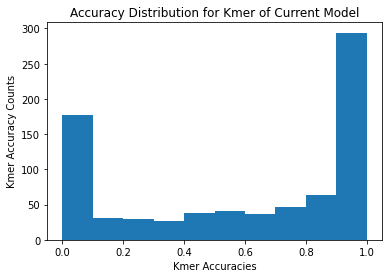

In [ ]:
# Plot Accuracy Graph among 5-mers
import matplotlib.pyplot as plt

dataModelAccuracies = [val for val in accuracyDict.values() if val >= 0]
n, bins, patches = plt.hist(dataModelAccuracies, 10)
plt.title("Accuracy Distribution for Kmer of Current Model")
plt.ylabel("Kmer Accuracy Counts")
plt.xlabel("Kmer Accuracies")
plt.show()

In [ ]:
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

@ignore_warnings(category=ConvergenceWarning)
def UpdatedKmerPredictionAccuracy(directRNADataFrame, ivtDataFrame, category):
    motifAccuracyModelDict = {}
    a = "ATGC"
    for eachMotif in itertools.product(a, repeat = 5):
        currentMotif = ''.join(eachMotif)
        dfDirectMotif = directRNADataFrame.loc[directRNADataFrame['reference_kmer'] == currentMotif]
        dfDirectMotif = dfDirectMotif.loc[dfDirectMotif['model_kmer'] != 'NNNNN']
        dfIVTMotif = ivtDataFrame.loc[ivtDataFrame['reference_kmer'] == currentMotif]
        dfIVTMotif = dfIVTMotif.loc[dfIVTMotif['model_kmer'] != 'NNNNN']
        
        if len(dfDirectMotif) > 1 and len(dfIVTMotif) > 1:
            km = KMeans(n_clusters = 2)
            dfDirectMotif["cluster"] = km.fit_predict(dfDirectMotif[category])

            if len(set(dfDirectMotif['cluster'])) > 1:
                listOfClusterVals = list(dfDirectMotif['cluster'])
                actualIVTVal = max(listOfClusterVals, key = listOfClusterVals.count)

                logModel = linear_model.LogisticRegression(solver = "liblinear", class_weight = "balanced")
                logModel.fit(dfDirectMotif[category], dfDirectMotif['cluster'])

                predictedVals = list(logModel.predict(dfIVTMotif[category]))
                motifAccuracyModelDict[currentMotif] = predictedVals.count(actualIVTVal)/len(predictedVals)
            else:
                motifAccuracyModelDict[currentMotif] = -1  
        else:
            motifAccuracyModelDict[currentMotif] = -1
    return motifAccuracyModelDict

In [ ]:
# Creates a list of the categories (excluding ID and class)
categories = [category for category in dfDirect.keys()]
categories.remove("reference_kmer")
categories.remove("contig")
categories.remove("strand")
categories.remove("model_kmer")
categories.remove("standardized_level")
categories.remove("model_mean")
categories.remove("model_stdv")
accuracyCategoryDict = {}

for category in categories:
    category = [category]
    categoryDict = UpdatedKmerPredictionAccuracy(dfDirect, dfIVT, category)
    accuracyCategoryDict[category[0]] = categoryDict
    print(category[0] + ":")
    print(categoryDict)

position:
{'AAAAA': 1.0, 'AAAAT': 1.0, 'AAAAG': 1.0, 'AAAAC': 0.0, 'AAATA': 1.0, 'AAATT': -1, 'AAATG': 0.0, 'AAATC': 1.0, 'AAAGA': -1, 'AAAGT': -1, 'AAAGG': 0.11607142857142858, 'AAAGC': 1.0, 'AAACA': -1, 'AAACT': 0.0, 'AAACG': -1, 'AAACC': 0.0, 'AATAA': -1, 'AATAT': -1, 'AATAG': -1, 'AATAC': -1, 'AATTA': 0.0, 'AATTT': -1, 'AATTG': -1, 'AATTC': -1, 'AATGA': -1, 'AATGT': 1.0, 'AATGG': 0.0, 'AATGC': 0.0, 'AATCA': -1, 'AATCT': -1, 'AATCG': -1, 'AATCC': -1, 'AAGAA': 0.32142857142857145, 'AAGAT': 1.0, 'AAGAG': 0.0, 'AAGAC': 0.0, 'AAGTA': 0.3448275862068966, 'AAGTT': -1, 'AAGTG': 1.0, 'AAGTC': 0.16666666666666666, 'AAGGA': 0.08196721311475409, 'AAGGT': 0.3170731707317073, 'AAGGG': 1.0, 'AAGGC': 0.0, 'AAGCA': 1.0, 'AAGCT': 0.08465608465608465, 'AAGCG': -1, 'AAGCC': 0.3194444444444444, 'AACAA': 0.0, 'AACAT': -1, 'AACAG': 1.0, 'AACAC': -1, 'AACTA': -1, 'AACTT': -1, 'AACTG': -1, 'AACTC': -1, 'AACGA': -1, 'AACGT': -1, 'AACGG': 0.0, 'AACGC': -1, 'AACCA': 1.0, 'AACCT': -1, 'AACCG': -1, 'AACCC': 0.0

In [ ]:
from statistics import mean
for category, motifAccuracies in accuracyCategoryDict.items():
    nonNegMotifAccuracies = [val for val in motifAccuracies.values() if val >= 0]
    print(category + ":" + str(mean(nonNegMotifAccuracies)))

position:0.25435191210660857
read_index:0.6002494921246185
event_index:0.6936040999749286
event_level_mean:0.5104572843920683
event_stdv:0.6721217912202812
event_length:0.6975458085428581


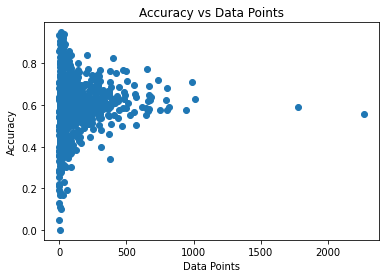

In [ ]:
correlationDict = {}
xValuesNumberPointsData = []
yValuesAccuracyGuess = []
a = "ATGC"
for eachMotif in itertools.product(a, repeat = 5):
    currentMotif = ''.join(eachMotif)
    correlationDict[currentMotif] = []
    for motifDictionaries in accuracyCategoryDict.values():
        if motifDictionaries[currentMotif] >= 0:
            correlationDict[currentMotif].append(motifDictionaries[currentMotif])   
    if len(correlationDict[currentMotif]) > 0:
        xValuesNumberPointsData.append(motifDataDictionary.get(currentMotif))
        yValuesAccuracyGuess.append(mean(correlationDict[currentMotif]))

plt.scatter(xValuesNumberPointsData, yValuesAccuracyGuess)
plt.title("Accuracy vs Data Points")
plt.xlabel("Data Points")
plt.ylabel("Accuracy")
plt.show()

0.7079785183737134


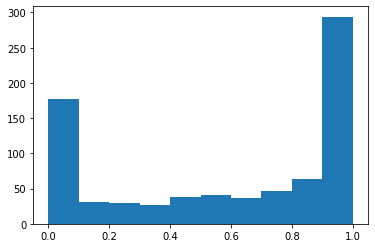

In [ ]:
completeCategoryDict = UpdatedKmerPredictionAccuracy(dfDirect, dfIVT, categories)
nonNegCompleteAccuracies = [val for val in completeCategoryDict.values() if val >= 0]
print(str(mean(nonNegCompleteAccuracies)))
n, bins, patches = plt.hist(dataModelAccuracies, 10)
plt.show()

In [ ]:
# Mean Shift
from sklearn.cluster import MeanShift

# Testing with 5mer
dfCCCCC = dfDirect[dfDirect['reference_kmer'] == 'AAAAA']
dfCCCCC = dfCCCCC[dfCCCCC['model_kmer'] != 'NNNNN']

meanShift = MeanShift(bin_seeding=True)
dfCCCCC['cluster'] = meanShift.fit_predict(dfCCCCC[['event_level_mean']])

clusterList = list(dfCCCCC['cluster'])
noModCluster = max(clusterList, key = clusterList.count)

logModel = linear_model.LogisticRegression(solver = "liblinear", class_weight = "balanced")
logModel.fit(dfCCCCC[['event_level_mean']], dfCCCCC['cluster'])

dfIVTCCCCC = dfIVT[dfIVT['reference_kmer'] == 'AAAAA']
dfIVTCCCCC = dfIVTCCCCC[dfIVTCCCCC['model_kmer'] != 'NNNNN']

predictedVals = list(logModel.predict(dfIVTCCCCC[['event_level_mean']]))
print("Accuracy: " + str(predictedVals.count(noModCluster)/len(predictedVals)))


Accuracy: 1.0


In [ ]:
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

@ignore_warnings(category=ConvergenceWarning)
def UpdatedKmerPredictionAccuracyMeanShift(directRNADataFrame, ivtDataFrame, category):
    motifAccuracyModelDict = {}
    a = "ATGC"
    for eachMotif in itertools.product(a, repeat = 5):
        currentMotif = ''.join(eachMotif)
        dfDirectMotif = directRNADataFrame.loc[directRNADataFrame['reference_kmer'] == currentMotif]
        dfDirectMotif = dfDirectMotif.loc[dfDirectMotif['model_kmer'] != 'NNNNN']
        dfIVTMotif = ivtDataFrame.loc[ivtDataFrame['reference_kmer'] == currentMotif]
        dfIVTMotif = dfIVTMotif.loc[dfIVTMotif['model_kmer'] != 'NNNNN']
        
        if len(dfDirectMotif) > 1 and len(dfIVTMotif) > 1:
            meansShift = MeanShift(bandwidth=1.0)
            dfDirectMotif["cluster"] = meansShift.fit_predict(dfDirectMotif[category])

            if len(set(dfDirectMotif['cluster'])) == 2:
                listOfClusterVals = list(dfDirectMotif['cluster'])
                actualIVTVal = max(listOfClusterVals, key = listOfClusterVals.count)

                logModel = linear_model.LogisticRegression(solver = "liblinear", class_weight = "balanced")
                logModel.fit(dfDirectMotif[category], dfDirectMotif['cluster'])

                predictedVals = list(logModel.predict(dfIVTMotif[category]))
                motifAccuracyModelDict[currentMotif] = predictedVals.count(actualIVTVal)/len(predictedVals)
            else:
                motifAccuracyModelDict[currentMotif] = -1  
        else:
            motifAccuracyModelDict[currentMotif] = -2
    return motifAccuracyModelDict

In [ ]:
categories = [category for category in dfDirect.keys()]
categories.remove("reference_kmer")
categories.remove("contig")
categories.remove("strand")
categories.remove("model_kmer")
categories.remove("standardized_level")
categories.remove("model_mean")
categories.remove("model_stdv")
accuracyCategoryDict = {}

for category in categories:
    category = [category]
    categoryDict = UpdatedKmerPredictionAccuracyMeanShift(dfDirect, dfIVT, category)
    accuracyCategoryDict[category[0]] = categoryDict
    print(category[0] + ":")
    print(categoryDict)

position:
{'AAAAA': -1, 'AAAAT': -1, 'AAAAG': -1, 'AAAAC': 0.0, 'AAATA': 1.0, 'AAATT': -1, 'AAATG': -1, 'AAATC': 1.0, 'AAAGA': -1, 'AAAGT': -1, 'AAAGG': -1, 'AAAGC': -1, 'AAACA': -1, 'AAACT': 0.0, 'AAACG': -1, 'AAACC': -1, 'AATAA': -1, 'AATAT': -1, 'AATAG': -2, 'AATAC': -1, 'AATTA': 0.0, 'AATTT': -1, 'AATTG': -1, 'AATTC': -2, 'AATGA': -1, 'AATGT': 1.0, 'AATGG': -1, 'AATGC': 0.0, 'AATCA': -1, 'AATCT': -1, 'AATCG': -2, 'AATCC': -1, 'AAGAA': -1, 'AAGAT': -1, 'AAGAG': -1, 'AAGAC': 0.0, 'AAGTA': -1, 'AAGTT': -2, 'AAGTG': 1.0, 'AAGTC': -1, 'AAGGA': -1, 'AAGGT': -1, 'AAGGG': 1.0, 'AAGGC': -1, 'AAGCA': -1, 'AAGCT': -1, 'AAGCG': -2, 'AAGCC': -1, 'AACAA': -1, 'AACAT': -1, 'AACAG': -1, 'AACAC': -1, 'AACTA': -1, 'AACTT': -2, 'AACTG': -2, 'AACTC': -2, 'AACGA': -2, 'AACGT': -2, 'AACGG': 0.0, 'AACGC': -2, 'AACCA': -1, 'AACCT': -2, 'AACCG': -2, 'AACCC': -1, 'ATAAA': -2, 'ATAAT': -2, 'ATAAG': -1, 'ATAAC': -2, 'ATATA': -2, 'ATATT': -1, 'ATATG': -2, 'ATATC': -1, 'ATAGA': -1, 'ATAGT': -1, 'ATAGG': -2, 'AT

In [ ]:
for category, motifAccuracies in accuracyCategoryDict.items():
    nonNegMotifAccuracies = [val for val in motifAccuracies.values() if val >= 0]
    if len(nonNegMotifAccuracies) > 0:
        print(category + ":" + str(mean(nonNegMotifAccuracies)))

position:0.25277431735567807
read_index:0.5057082650029335
event_index:0.4467273930488832
event_level_mean:0.5509547876206846
event_stdv:0.7244459502672744


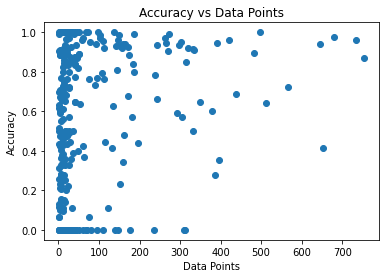

In [ ]:
correlationDict = {}
xValuesNumberPointsData = []
yValuesAccuracyGuess = []
a = "ATGC"
for eachMotif in itertools.product(a, repeat = 5):
    currentMotif = ''.join(eachMotif)
    correlationDict[currentMotif] = []
    for motifDictionaries in accuracyCategoryDict.values():
        if motifDictionaries[currentMotif] >= 0:
            correlationDict[currentMotif].append(motifDictionaries[currentMotif])   
    if len(correlationDict[currentMotif]) > 0:
        xValuesNumberPointsData.append(motifDataDictionary.get(currentMotif))
        yValuesAccuracyGuess.append(mean(correlationDict[currentMotif]))

plt.scatter(xValuesNumberPointsData, yValuesAccuracyGuess)
plt.title("Accuracy vs Data Points")
plt.xlabel("Data Points")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
completeCategoryDict = UpdatedKmerPredictionAccuracyMeanShift(dfDirect, dfIVT, categories)
nonNegCompleteAccuracies = [val for val in completeCategoryDict.values() if val >= 0]
print(str(mean(nonNegCompleteAccuracies)))

0.4790849298274038


In [ ]:
from sklearn.cluster import DBSCAN

@ignore_warnings(category=ConvergenceWarning)
def UpdatedKmerPredictionAccuracyDBSCAN(directRNADataFrame, ivtDataFrame, category):
    motifAccuracyModelDict = {}
    a = "ATGC"
    for eachMotif in itertools.product(a, repeat = 5):
        currentMotif = ''.join(eachMotif)
        dfDirectMotif = directRNADataFrame.loc[directRNADataFrame['reference_kmer'] == currentMotif]
        dfDirectMotif = dfDirectMotif.loc[dfDirectMotif['model_kmer'] != 'NNNNN']
        dfIVTMotif = ivtDataFrame.loc[ivtDataFrame['reference_kmer'] == currentMotif]
        dfIVTMotif = dfIVTMotif.loc[dfIVTMotif['model_kmer'] != 'NNNNN']
        
        if len(dfDirectMotif) > 1 and len(dfIVTMotif) > 1:
            dbscanCluster = DBSCAN(eps=0.25, min_samples=10)
            dfDirectMotif["cluster"] = dbscanCluster.fit_predict(dfDirectMotif[category])

            if len(set(dfDirectMotif['cluster'])) == 2:
                listOfClusterVals = list(dfDirectMotif['cluster'])
                actualIVTVal = max(listOfClusterVals, key = listOfClusterVals.count)

                logModel = linear_model.LogisticRegression(solver = "liblinear", class_weight = "balanced")
                logModel.fit(dfDirectMotif[category], dfDirectMotif['cluster'])

                predictedVals = list(logModel.predict(dfIVTMotif[category]))
                motifAccuracyModelDict[currentMotif] = predictedVals.count(actualIVTVal)/len(predictedVals)
            else:
                motifAccuracyModelDict[currentMotif] = -1  
        else:
            motifAccuracyModelDict[currentMotif] = -1
    return motifAccuracyModelDict

In [ ]:
categories = [category for category in dfDirect.keys()]
categories.remove("reference_kmer")
categories.remove("contig")
categories.remove("strand")
categories.remove("model_kmer")
categories.remove("standardized_level")
categories.remove("model_mean")
categories.remove("model_stdv")
accuracyCategoryDict = {}

for category in categories:
    category = [category]
    categoryDict = UpdatedKmerPredictionAccuracyDBSCAN(dfDirect, dfIVT, category)
    accuracyCategoryDict[category[0]] = categoryDict
    print(category[0] + ":")
    print(categoryDict)

position:
{'AAAAA': -1, 'AAAAT': -1, 'AAAAG': -1, 'AAAAC': 0.0, 'AAATA': 1.0, 'AAATT': -1, 'AAATG': 0.0, 'AAATC': -1, 'AAAGA': -1, 'AAAGT': -1, 'AAAGG': -1, 'AAAGC': -1, 'AAACA': -1, 'AAACT': -1, 'AAACG': -1, 'AAACC': 1.0, 'AATAA': -1, 'AATAT': -1, 'AATAG': -1, 'AATAC': -1, 'AATTA': 0.0, 'AATTT': -1, 'AATTG': -1, 'AATTC': -1, 'AATGA': -1, 'AATGT': 1.0, 'AATGG': 0.0, 'AATGC': -1, 'AATCA': -1, 'AATCT': -1, 'AATCG': -1, 'AATCC': -1, 'AAGAA': -1, 'AAGAT': -1, 'AAGAG': -1, 'AAGAC': -1, 'AAGTA': 0.3448275862068966, 'AAGTT': -1, 'AAGTG': 1.0, 'AAGTC': -1, 'AAGGA': -1, 'AAGGT': -1, 'AAGGG': 1.0, 'AAGGC': -1, 'AAGCA': -1, 'AAGCT': -1, 'AAGCG': -1, 'AAGCC': -1, 'AACAA': -1, 'AACAT': -1, 'AACAG': -1, 'AACAC': -1, 'AACTA': -1, 'AACTT': -1, 'AACTG': -1, 'AACTC': -1, 'AACGA': -1, 'AACGT': -1, 'AACGG': 0.0, 'AACGC': -1, 'AACCA': -1, 'AACCT': -1, 'AACCG': -1, 'AACCC': 0.0, 'ATAAA': -1, 'ATAAT': -1, 'ATAAG': -1, 'ATAAC': -1, 'ATATA': -1, 'ATATT': -1, 'ATATG': -1, 'ATATC': -1, 'ATAGA': -1, 'ATAGT': -1, 

In [ ]:
for category, motifAccuracies in accuracyCategoryDict.items():
    nonNegMotifAccuracies = [val for val in motifAccuracies.values() if val >= 0]
    if len(nonNegMotifAccuracies) > 0:
        print(category + ":" + str(mean(nonNegMotifAccuracies)))

position:0.2833696408423933
read_index:0.5580879640666833
event_level_mean:0.5331242141130397
event_stdv:0.7583509353399077


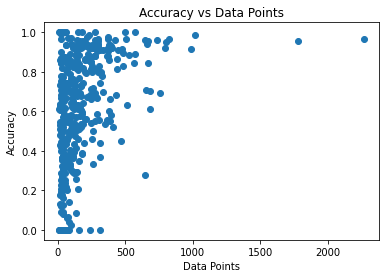

In [ ]:
correlationDict = {}
xValuesNumberPointsData = []
yValuesAccuracyGuess = []
a = "ATGC"
for eachMotif in itertools.product(a, repeat = 5):
    currentMotif = ''.join(eachMotif)
    correlationDict[currentMotif] = []
    for motifDictionaries in accuracyCategoryDict.values():
        if motifDictionaries[currentMotif] >= 0:
            correlationDict[currentMotif].append(motifDictionaries[currentMotif])   
    if len(correlationDict[currentMotif]) > 0:
        xValuesNumberPointsData.append(motifDataDictionary.get(currentMotif))
        yValuesAccuracyGuess.append(mean(correlationDict[currentMotif]))

plt.scatter(xValuesNumberPointsData, yValuesAccuracyGuess)
plt.title("Accuracy vs Data Points")
plt.xlabel("Data Points")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
completeCategoryDict = UpdatedKmerPredictionAccuracyDBSCAN(dfDirect, dfIVT, categories)
nonNegCompleteAccuracies = [val for val in completeCategoryDict.values() if val >= 0]
print(str(mean(nonNegCompleteAccuracies)))

StatisticsError: ignored

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

@ignore_warnings(category=ConvergenceWarning)
def UpdatedKmerPredictionAccuracyKMeansPrediction(directRNADataFrame, ivtDataFrame, category):
    motifAccuracyModelDict = {}
    a = "ATGC"
    for eachMotif in itertools.product(a, repeat = 5):
        currentMotif = ''.join(eachMotif)
        dfDirectMotif = directRNADataFrame.loc[directRNADataFrame['reference_kmer'] == currentMotif]
        dfDirectMotif = dfDirectMotif.loc[dfDirectMotif['model_kmer'] != 'NNNNN']
        dfIVTMotif = ivtDataFrame.loc[ivtDataFrame['reference_kmer'] == currentMotif]
        dfIVTMotif = dfIVTMotif.loc[dfIVTMotif['model_kmer'] != 'NNNNN']
        if len(dfDirectMotif) > 1 and len(dfIVTMotif) > 1:
            km = KMeans(n_clusters = 2)
            dfDirectMotif["cluster"] = km.fit_predict(dfDirectMotif[category])

            #if len(set(dfDirectMotif['cluster'])) > 0:
            listOfClusterVals = list(dfDirectMotif['cluster'])
            actualIVTVal = max(listOfClusterVals, key = listOfClusterVals.count)

            #logModel = linear_model.LogisticRegression(solver = "liblinear", class_weight = "balanced")
            #logModel.fit(dfDirectMotif[category], dfDirectMotif['cluster'])
            '''
            scalar = StandardScaler()
            X_train = list(dfDirectMotif[category])
            scalar.fit(X_train)
            X_train = scalar.transform(X_train)
            X_test = scalar.transform(list(dfIVTMotif[category]))
            '''
                
            classifer = KNeighborsClassifier(n_neighbors=2)
            classifer.fit(dfDirectMotif[category], dfDirectMotif['cluster'])


            predictedVals = list(classifer.predict(dfIVTMotif[category]))
            motifAccuracyModelDict[currentMotif] = predictedVals.count(actualIVTVal)/len(predictedVals)
            #else:
            #   motifAccuracyModelDict[currentMotif] = -1  
        else:
            motifAccuracyModelDict[currentMotif] = -1
    return motifAccuracyModelDict

In [ ]:
categories = [category for category in dfDirect.keys()]
categories.remove("reference_kmer")
categories.remove("contig")
categories.remove("strand")
categories.remove("model_kmer")
categories.remove("standardized_level")
categories.remove("model_mean")
categories.remove("model_stdv")
accuracyCategoryDict = {}

for category in categories:
    category = [category]
    categoryDict = UpdatedKmerPredictionAccuracyKMeansPrediction(dfDirect, dfIVT, category)
    accuracyCategoryDict[category[0]] = categoryDict
    print(category[0] + ":")
    print(categoryDict)

position:
{'AAAAA': 1.0, 'AAAAT': 1.0, 'AAAAG': 1.0, 'AAAAC': 0.0, 'AAATA': 1.0, 'AAATT': 1.0, 'AAATG': 0.42857142857142855, 'AAATC': 0.9473684210526315, 'AAAGA': 1.0, 'AAAGT': 1.0, 'AAAGG': 0.11607142857142858, 'AAAGC': 1.0, 'AAACA': 1.0, 'AAACT': 0.0, 'AAACG': 1.0, 'AAACC': 0.0, 'AATAA': 1.0, 'AATAT': 1.0, 'AATAG': -1, 'AATAC': 1.0, 'AATTA': 0.0, 'AATTT': 1.0, 'AATTG': 1.0, 'AATTC': -1, 'AATGA': 1.0, 'AATGT': 0.8181818181818182, 'AATGG': 0.0, 'AATGC': 0.23076923076923078, 'AATCA': 1.0, 'AATCT': 1.0, 'AATCG': -1, 'AATCC': 1.0, 'AAGAA': 0.32142857142857145, 'AAGAT': 1.0, 'AAGAG': 0.0, 'AAGAC': 1.0, 'AAGTA': 0.3448275862068966, 'AAGTT': -1, 'AAGTG': 1.0, 'AAGTC': 0.16666666666666666, 'AAGGA': 0.08196721311475409, 'AAGGT': 0.3170731707317073, 'AAGGG': 1.0, 'AAGGC': 0.10833333333333334, 'AAGCA': 1.0, 'AAGCT': 0.08465608465608465, 'AAGCG': -1, 'AAGCC': 1.0, 'AACAA': 0.02564102564102564, 'AACAT': 1.0, 'AACAG': 0.9416058394160584, 'AACAC': 1.0, 'AACTA': 1.0, 'AACTT': -1, 'AACTG': -1, 'AACTC'

In [ ]:
for category, motifAccuracies in accuracyCategoryDict.items():
    nonNegMotifAccuracies = [val for val in motifAccuracies.values() if val >= 0]
    if len(nonNegMotifAccuracies) > 0:
        print(category + ":" + str(mean(nonNegMotifAccuracies)))

position:0.48728394466339814
read_index:0.6143830829247875
event_index:0.7210947285403313
event_level_mean:0.589477682214983
event_stdv:0.7544604209771794
event_length:0.7737922765548978


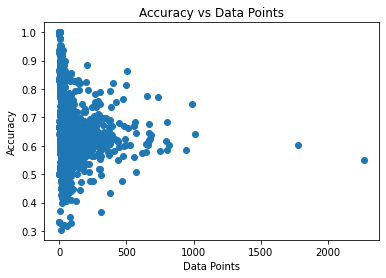

In [ ]:
correlationDict = {}
xValuesNumberPointsData = []
yValuesAccuracyGuess = []
a = "ATGC"
for eachMotif in itertools.product(a, repeat = 5):
    currentMotif = ''.join(eachMotif)
    correlationDict[currentMotif] = []
    for motifDictionaries in accuracyCategoryDict.values():
        if motifDictionaries[currentMotif] >= 0:
            correlationDict[currentMotif].append(motifDictionaries[currentMotif])   
    if len(correlationDict[currentMotif]) > 0:
        xValuesNumberPointsData.append(motifDataDictionary.get(currentMotif))
        yValuesAccuracyGuess.append(mean(correlationDict[currentMotif]))

plt.scatter(xValuesNumberPointsData, yValuesAccuracyGuess)
plt.title("Accuracy vs Data Points")
plt.xlabel("Data Points")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
completeCategoryDict = UpdatedKmerPredictionAccuracyKMeansPrediction(dfDirect, dfIVT, categories)
nonNegCompleteAccuracies = [val for val in completeCategoryDict.values() if val >= 0]
print(str(mean(nonNegCompleteAccuracies)))

0.7266037567254633


In [ ]:
@ignore_warnings(category=ConvergenceWarning)
def UpdatedKmerPredictionAccuracyMeanShift2(directRNADataFrame, ivtDataFrame, category):
    motifAccuracyModelDict = {}
    a = "ATGC"
    for eachMotif in itertools.product(a, repeat = 5):
        currentMotif = ''.join(eachMotif)
        dfDirectMotif = directRNADataFrame.loc[directRNADataFrame['reference_kmer'] == currentMotif]
        dfDirectMotif = dfDirectMotif.loc[dfDirectMotif['model_kmer'] != 'NNNNN']
        dfIVTMotif = ivtDataFrame.loc[ivtDataFrame['reference_kmer'] == currentMotif]
        dfIVTMotif = dfIVTMotif.loc[dfIVTMotif['model_kmer'] != 'NNNNN']
        if len(dfDirectMotif) > 1 and len(dfIVTMotif) > 1:
            meansShift = MeanShift(bandwidth=1.0)
            dfDirectMotif["cluster"] = meansShift.fit_predict(dfDirectMotif[category])

            #if len(set(dfDirectMotif['cluster'])) > 0:
            listOfClusterVals = list(dfDirectMotif['cluster'])
            actualIVTVal = max(listOfClusterVals, key = listOfClusterVals.count)

            #logModel = linear_model.LogisticRegression(solver = "liblinear", class_weight = "balanced")
            #logModel.fit(dfDirectMotif[category], dfDirectMotif['cluster'])
            '''
            scalar = StandardScaler()
            X_train = list(dfDirectMotif[category])
            scalar.fit(X_train)
            X_train = scalar.transform(X_train)
            X_test = scalar.transform(list(dfIVTMotif[category]))
            '''
                
            classifer = KNeighborsClassifier(n_neighbors=len(set(dfDirectMotif['cluster'])))
            classifer.fit(dfDirectMotif[category], dfDirectMotif['cluster'])


            predictedVals = list(classifer.predict(dfIVTMotif[category]))
            motifAccuracyModelDict[currentMotif] = predictedVals.count(actualIVTVal)/len(predictedVals)
            #else:
            #   motifAccuracyModelDict[currentMotif] = -1  
        else:
            motifAccuracyModelDict[currentMotif] = -1
    return motifAccuracyModelDict

In [ ]:
categories = [category for category in dfDirect.keys()]
categories.remove("reference_kmer")
categories.remove("contig")
categories.remove("strand")
categories.remove("model_kmer")
categories.remove("standardized_level")
categories.remove("model_mean")
categories.remove("model_stdv")
accuracyCategoryDict = {}

for category in categories:
    category = [category]
    categoryDict = UpdatedKmerPredictionAccuracyMeanShift2(dfDirect, dfIVT, category)
    accuracyCategoryDict[category[0]] = categoryDict
    print(category[0] + ":")
    print(categoryDict)

position:
{'AAAAA': 0.9904761904761905, 'AAAAT': 0.05511811023622047, 'AAAAG': 0.0, 'AAAAC': 0.0, 'AAATA': 1.0, 'AAATT': 1.0, 'AAATG': 0.07142857142857142, 'AAATC': 0.9473684210526315, 'AAAGA': 1.0, 'AAAGT': 1.0, 'AAAGG': 0.11607142857142858, 'AAAGC': 0.0, 'AAACA': 1.0, 'AAACT': 0.0, 'AAACG': 1.0, 'AAACC': 0.0, 'AATAA': 1.0, 'AATAT': 1.0, 'AATAG': -1, 'AATAC': 1.0, 'AATTA': 0.0, 'AATTT': 1.0, 'AATTG': 1.0, 'AATTC': -1, 'AATGA': 1.0, 'AATGT': 0.8181818181818182, 'AATGG': 0.0, 'AATGC': 0.23076923076923078, 'AATCA': 1.0, 'AATCT': 1.0, 'AATCG': -1, 'AATCC': 1.0, 'AAGAA': 0.32142857142857145, 'AAGAT': 0.020833333333333332, 'AAGAG': 0.01293103448275862, 'AAGAC': 1.0, 'AAGTA': 0.3448275862068966, 'AAGTT': -1, 'AAGTG': 1.0, 'AAGTC': 0.12, 'AAGGA': 0.08196721311475409, 'AAGGT': 0.3170731707317073, 'AAGGG': 1.0, 'AAGGC': 0.10833333333333334, 'AAGCA': 0.0, 'AAGCT': 0.08465608465608465, 'AAGCG': -1, 'AAGCC': 0.09722222222222222, 'AACAA': 0.01282051282051282, 'AACAT': 1.0, 'AACAG': 0.94160583941605

In [ ]:
for category, motifAccuracies in accuracyCategoryDict.items():
    nonNegMotifAccuracies = [val for val in motifAccuracies.values() if val >= 0]
    if len(nonNegMotifAccuracies) > 0:
        print(category + ":" + str(mean(nonNegMotifAccuracies)))

position:0.3980363115084954
read_index:0.3251549548401354
event_index:0.408656573006027
event_level_mean:0.4175986747798767
event_stdv:0.7826470236905435
event_length:1.0


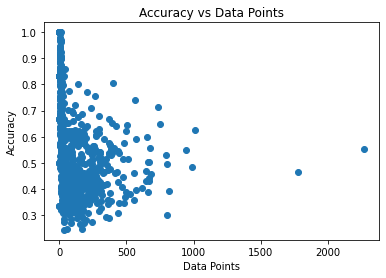

In [ ]:
correlationDict = {}
xValuesNumberPointsData = []
yValuesAccuracyGuess = []
a = "ATGC"
for eachMotif in itertools.product(a, repeat = 5):
    currentMotif = ''.join(eachMotif)
    correlationDict[currentMotif] = []
    for motifDictionaries in accuracyCategoryDict.values():
        if motifDictionaries[currentMotif] >= 0:
            correlationDict[currentMotif].append(motifDictionaries[currentMotif])   
    if len(correlationDict[currentMotif]) > 0:
        xValuesNumberPointsData.append(motifDataDictionary.get(currentMotif))
        yValuesAccuracyGuess.append(mean(correlationDict[currentMotif]))

plt.scatter(xValuesNumberPointsData, yValuesAccuracyGuess)
plt.title("Accuracy vs Data Points")
plt.xlabel("Data Points")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
completeCategoryDict = UpdatedKmerPredictionAccuracyMeanShift2(dfDirect, dfIVT, categories)
nonNegCompleteAccuracies = [val for val in completeCategoryDict.values() if val >= 0]
print(str(mean(nonNegCompleteAccuracies)))

0.024296675191815855


In [ ]:
@ignore_warnings(category=ConvergenceWarning)
def UpdatedKmerPredictionAccuracyDBSCAN2(directRNADataFrame, ivtDataFrame, category):
    motifAccuracyModelDict = {}
    a = "ATGC"
    for eachMotif in itertools.product(a, repeat = 5):
        currentMotif = ''.join(eachMotif)
        dfDirectMotif = directRNADataFrame.loc[directRNADataFrame['reference_kmer'] == currentMotif]
        dfDirectMotif = dfDirectMotif.loc[dfDirectMotif['model_kmer'] != 'NNNNN']
        dfIVTMotif = ivtDataFrame.loc[ivtDataFrame['reference_kmer'] == currentMotif]
        dfIVTMotif = dfIVTMotif.loc[dfIVTMotif['model_kmer'] != 'NNNNN']
        if len(dfDirectMotif) > 1 and len(dfIVTMotif) > 1:
            dbscanCluster = DBSCAN(eps=0.25, min_samples=10)
            dfDirectMotif["cluster"] = dbscanCluster.fit_predict(dfDirectMotif[category])

            listOfClusterVals = list(dfDirectMotif['cluster'])
            actualIVTVal = max(listOfClusterVals, key = listOfClusterVals.count)
                
            classifer = KNeighborsClassifier(n_neighbors=len(set(dfDirectMotif['cluster'])))
            classifer.fit(dfDirectMotif[category], dfDirectMotif['cluster'])


            predictedVals = list(classifer.predict(dfIVTMotif[category]))
            motifAccuracyModelDict[currentMotif] = predictedVals.count(actualIVTVal)/len(predictedVals)

        else:
            motifAccuracyModelDict[currentMotif] = -1
    return motifAccuracyModelDict

In [ ]:
categories = [category for category in dfDirect.keys()]
categories.remove("reference_kmer")
categories.remove("contig")
categories.remove("strand")
categories.remove("model_kmer")
categories.remove("standardized_level")
categories.remove("model_mean")
categories.remove("model_stdv")
accuracyCategoryDict = {}

for category in categories:
    category = [category]
    categoryDict = UpdatedKmerPredictionAccuracyDBSCAN2(dfDirect, dfIVT, category)
    accuracyCategoryDict[category[0]] = categoryDict
    print(category[0] + ":")
    print(categoryDict)

position:
{'AAAAA': 1.0, 'AAAAT': 0.05511811023622047, 'AAAAG': 0.0, 'AAAAC': 0.0, 'AAATA': 1.0, 'AAATT': 1.0, 'AAATG': 0.07142857142857142, 'AAATC': 1.0, 'AAAGA': 1.0, 'AAAGT': 1.0, 'AAAGG': 0.11607142857142858, 'AAAGC': 1.0, 'AAACA': 1.0, 'AAACT': 1.0, 'AAACG': 1.0, 'AAACC': 1.0, 'AATAA': 1.0, 'AATAT': 1.0, 'AATAG': -1, 'AATAC': 1.0, 'AATTA': 0.0, 'AATTT': 1.0, 'AATTG': 1.0, 'AATTC': -1, 'AATGA': 1.0, 'AATGT': 0.8181818181818182, 'AATGG': 0.0, 'AATGC': 1.0, 'AATCA': 1.0, 'AATCT': 1.0, 'AATCG': -1, 'AATCC': 1.0, 'AAGAA': 0.32142857142857145, 'AAGAT': 1.0, 'AAGAG': 0.01293103448275862, 'AAGAC': 1.0, 'AAGTA': 0.3448275862068966, 'AAGTT': -1, 'AAGTG': 1.0, 'AAGTC': 0.12, 'AAGGA': 0.08196721311475409, 'AAGGT': 0.3170731707317073, 'AAGGG': 1.0, 'AAGGC': 0.10833333333333334, 'AAGCA': 0.0, 'AAGCT': 0.08465608465608465, 'AAGCG': -1, 'AAGCC': 0.09722222222222222, 'AACAA': 1.0, 'AACAT': 1.0, 'AACAG': 1.0, 'AACAC': 1.0, 'AACTA': 1.0, 'AACTT': -1, 'AACTG': -1, 'AACTC': -1, 'AACGA': -1, 'AACGT': -

In [ ]:
for category, motifAccuracies in accuracyCategoryDict.items():
    nonNegMotifAccuracies = [val for val in motifAccuracies.values() if val >= 0]
    if len(nonNegMotifAccuracies) > 0:
        print(category + ":" + str(mean(nonNegMotifAccuracies)))

position:0.49317609237960025
read_index:0.7968533758683694
event_index:1.0
event_level_mean:0.8744265464995142
event_stdv:0.8656566364727136
event_length:1.0


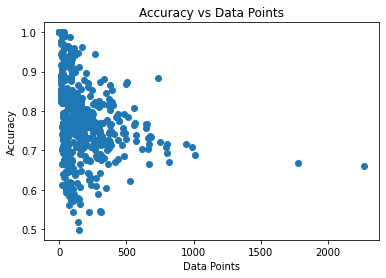

In [ ]:
correlationDict = {}
xValuesNumberPointsData = []
yValuesAccuracyGuess = []
a = "ATGC"
for eachMotif in itertools.product(a, repeat = 5):
    currentMotif = ''.join(eachMotif)
    correlationDict[currentMotif] = []
    for motifDictionaries in accuracyCategoryDict.values():
        if motifDictionaries[currentMotif] >= 0:
            correlationDict[currentMotif].append(motifDictionaries[currentMotif])   
    if len(correlationDict[currentMotif]) > 0:
        xValuesNumberPointsData.append(motifDataDictionary.get(currentMotif))
        yValuesAccuracyGuess.append(mean(correlationDict[currentMotif]))

plt.scatter(xValuesNumberPointsData, yValuesAccuracyGuess)
plt.title("Accuracy vs Data Points")
plt.xlabel("Data Points")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
completeCategoryDict = UpdatedKmerPredictionAccuracyDBSCAN2(dfDirect, dfIVT, categories)
nonNegCompleteAccuracies = [val for val in completeCategoryDict.values() if val >= 0]
print(str(mean(nonNegCompleteAccuracies)))

1.0


In [ ]:
@ignore_warnings(category=ConvergenceWarning)
def UpdatedKmerPredictionAccuracyKMeansPrediction3(directRNADataFrame, ivtDataFrame, category):
    motifAccuracyModelDict = {}
    a = "ATGC"
    for eachMotif in itertools.product(a, repeat = 5):
        currentMotif = ''.join(eachMotif)
        dfDirectMotif = directRNADataFrame.loc[directRNADataFrame['reference_kmer'] == currentMotif]
        dfDirectMotif = dfDirectMotif.loc[dfDirectMotif['model_kmer'] != 'NNNNN']
        dfIVTMotif = ivtDataFrame.loc[ivtDataFrame['reference_kmer'] == currentMotif]
        dfIVTMotif = dfIVTMotif.loc[dfIVTMotif['model_kmer'] != 'NNNNN']
        if len(dfDirectMotif) > 1 and len(dfIVTMotif) > 1:
            km = KMeans(n_clusters = 2)
            dfDirectMotif["cluster"] = km.fit_predict(dfDirectMotif[category])

            if len(set(dfDirectMotif['cluster'])) > 1:     
                classifer = KNeighborsClassifier(n_neighbors=2)
                classifer.fit(dfDirectMotif[category], dfDirectMotif['cluster'])


                predictedVals = list(classifer.predict(dfIVTMotif[category]))
                actualIVTVal = max(predictedVals, key = predictedVals.count)
                motifAccuracyModelDict[currentMotif] = predictedVals.count(actualIVTVal)/len(predictedVals)
            else:
                motifAccuracyModelDict[currentMotif] = -2
        else:
            motifAccuracyModelDict[currentMotif] = -1
    return motifAccuracyModelDict

In [ ]:
categories = [category for category in dfDirect.keys()]
categories.remove("reference_kmer")
categories.remove("contig")
categories.remove("strand")
categories.remove("model_kmer")
categories.remove("standardized_level")
categories.remove("model_mean")
categories.remove("model_stdv")
accuracyCategoryDict = {}

for category in categories:
    category = [category]
    categoryDict = UpdatedKmerPredictionAccuracyKMeansPrediction3(dfDirect, dfIVT, category)
    accuracyCategoryDict[category[0]] = categoryDict
    print(category[0] + ":")
    print(categoryDict)

position:
{'AAAAA': 1.0, 'AAAAT': 1.0, 'AAAAG': 1.0, 'AAAAC': 1.0, 'AAATA': 1.0, 'AAATT': -2, 'AAATG': 0.5714285714285714, 'AAATC': 0.9473684210526315, 'AAAGA': -2, 'AAAGT': -2, 'AAAGG': 0.8839285714285714, 'AAAGC': 1.0, 'AAACA': -2, 'AAACT': 1.0, 'AAACG': -2, 'AAACC': 1.0, 'AATAA': -2, 'AATAT': -2, 'AATAG': -1, 'AATAC': -2, 'AATTA': 1.0, 'AATTT': -2, 'AATTG': -2, 'AATTC': -1, 'AATGA': -2, 'AATGT': 0.8181818181818182, 'AATGG': 1.0, 'AATGC': 0.7692307692307693, 'AATCA': -2, 'AATCT': -2, 'AATCG': -1, 'AATCC': -2, 'AAGAA': 0.6785714285714286, 'AAGAT': 1.0, 'AAGAG': 1.0, 'AAGAC': 1.0, 'AAGTA': 0.6551724137931034, 'AAGTT': -1, 'AAGTG': 1.0, 'AAGTC': 0.8333333333333334, 'AAGGA': 0.9180327868852459, 'AAGGT': 0.6829268292682927, 'AAGGG': 1.0, 'AAGGC': 0.8916666666666667, 'AAGCA': 1.0, 'AAGCT': 0.9153439153439153, 'AAGCG': -1, 'AAGCC': 1.0, 'AACAA': 0.9743589743589743, 'AACAT': -2, 'AACAG': 0.9416058394160584, 'AACAC': -2, 'AACTA': -2, 'AACTT': -1, 'AACTG': -1, 'AACTC': -1, 'AACGA': -1, 'AACGT'

In [ ]:
for category, motifAccuracies in accuracyCategoryDict.items():
    nonNegMotifAccuracies = [val for val in motifAccuracies.values() if val >= 0]
    if len(nonNegMotifAccuracies) > 0:
        print(category + ":" + str(mean(nonNegMotifAccuracies)))

position:0.901252970799905
read_index:0.7021094670857293
event_index:0.9296250973001015
event_level_mean:0.7022866168868082
event_stdv:0.8170954280214057
event_length:0.8003363487984521


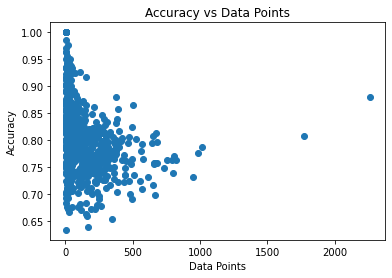

In [ ]:
correlationDict = {}
xValuesNumberPointsData = []
yValuesAccuracyGuess = []
a = "ATGC"
for eachMotif in itertools.product(a, repeat = 5):
    currentMotif = ''.join(eachMotif)
    correlationDict[currentMotif] = []
    for motifDictionaries in accuracyCategoryDict.values():
        if motifDictionaries[currentMotif] >= 0:
            correlationDict[currentMotif].append(motifDictionaries[currentMotif])   
    if len(correlationDict[currentMotif]) > 0:
        xValuesNumberPointsData.append(motifDataDictionary.get(currentMotif))
        yValuesAccuracyGuess.append(mean(correlationDict[currentMotif]))

plt.scatter(xValuesNumberPointsData, yValuesAccuracyGuess)
plt.title("Accuracy vs Data Points")
plt.xlabel("Data Points")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
completeCategoryDict = UpdatedKmerPredictionAccuracyKMeansPrediction3(dfDirect, dfIVT, categories)
nonNegCompleteAccuracies = [val for val in completeCategoryDict.values() if val >= 0]
print(str(mean(nonNegCompleteAccuracies)))

0.9395337074013999


In [ ]:
@ignore_warnings(category=ConvergenceWarning)
def UpdatedKmerPredictionAccuracyMeanShift3(directRNADataFrame, ivtDataFrame, category):
    motifAccuracyModelDict = {}
    a = "ATGC"
    for eachMotif in itertools.product(a, repeat = 5):
        currentMotif = ''.join(eachMotif)
        dfDirectMotif = directRNADataFrame.loc[directRNADataFrame['reference_kmer'] == currentMotif]
        dfDirectMotif = dfDirectMotif.loc[dfDirectMotif['model_kmer'] != 'NNNNN']
        dfIVTMotif = ivtDataFrame.loc[ivtDataFrame['reference_kmer'] == currentMotif]
        dfIVTMotif = dfIVTMotif.loc[dfIVTMotif['model_kmer'] != 'NNNNN']
        if len(dfDirectMotif) > 1 and len(dfIVTMotif) > 1:
            meansShift = MeanShift(bandwidth=1.0)
            dfDirectMotif["cluster"] = meansShift.fit_predict(dfDirectMotif[category])

            if len(set(dfDirectMotif['cluster'])) > 0:
                    
                classifer = KNeighborsClassifier(n_neighbors=len(set(dfDirectMotif['cluster'])))
                classifer.fit(dfDirectMotif[category], dfDirectMotif['cluster'])


                predictedVals = list(classifer.predict(dfIVTMotif[category]))
                actualIVTVal = max(predictedVals, key = predictedVals.count)
                motifAccuracyModelDict[currentMotif] = predictedVals.count(actualIVTVal)/len(predictedVals)
            else:
               motifAccuracyModelDict[currentMotif] = -2  
        else:
            motifAccuracyModelDict[currentMotif] = -1
    return motifAccuracyModelDict

In [ ]:
categories = [category for category in dfDirect.keys()]
categories.remove("reference_kmer")
categories.remove("contig")
categories.remove("strand")
categories.remove("model_kmer")
categories.remove("standardized_level")
categories.remove("model_mean")
categories.remove("model_stdv")
accuracyCategoryDict = {}

for category in categories:
    category = [category]
    categoryDict = UpdatedKmerPredictionAccuracyMeanShift3(dfDirect, dfIVT, category)
    accuracyCategoryDict[category[0]] = categoryDict
    print(category[0] + ":")
    print(categoryDict)

position:
{'AAAAA': 0.9904761904761905, 'AAAAT': 0.937007874015748, 'AAAAG': 1.0, 'AAAAC': 1.0, 'AAATA': 1.0, 'AAATT': 1.0, 'AAATG': 0.5714285714285714, 'AAATC': 0.9473684210526315, 'AAAGA': 1.0, 'AAAGT': 1.0, 'AAAGG': 0.8839285714285714, 'AAAGC': 1.0, 'AAACA': 1.0, 'AAACT': 1.0, 'AAACG': 1.0, 'AAACC': 0.9871794871794872, 'AATAA': 1.0, 'AATAT': 1.0, 'AATAG': -1, 'AATAC': 1.0, 'AATTA': 1.0, 'AATTT': 1.0, 'AATTG': 1.0, 'AATTC': -1, 'AATGA': 1.0, 'AATGT': 0.8181818181818182, 'AATGG': 0.9876543209876543, 'AATGC': 0.7692307692307693, 'AATCA': 1.0, 'AATCT': 1.0, 'AATCG': -1, 'AATCC': 1.0, 'AAGAA': 0.6785714285714286, 'AAGAT': 0.9791666666666666, 'AAGAG': 0.9568965517241379, 'AAGAC': 1.0, 'AAGTA': 0.5862068965517241, 'AAGTT': -1, 'AAGTG': 1.0, 'AAGTC': 0.7933333333333333, 'AAGGA': 0.8524590163934426, 'AAGGT': 0.6829268292682927, 'AAGGG': 1.0, 'AAGGC': 0.8916666666666667, 'AAGCA': 1.0, 'AAGCT': 0.9047619047619048, 'AAGCG': -1, 'AAGCC': 0.6805555555555556, 'AACAA': 0.9743589743589743, 'AACAT': 

In [ ]:
for category, motifAccuracies in accuracyCategoryDict.items():
    nonNegMotifAccuracies = [val for val in motifAccuracies.values() if val >= 0]
    if len(nonNegMotifAccuracies) > 0:
        print(category + ":" + str(mean(nonNegMotifAccuracies)))

position:0.9046329048695891
read_index:0.5841908374184009
event_index:0.8535891908735046
event_level_mean:0.5551406056513235
event_stdv:0.8301803137127096
event_length:1.0


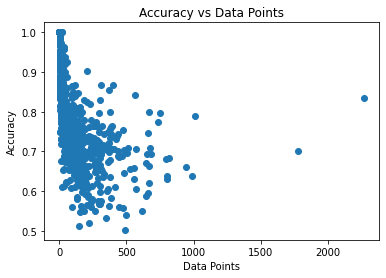

In [ ]:
correlationDict = {}
xValuesNumberPointsData = []
yValuesAccuracyGuess = []
a = "ATGC"
for eachMotif in itertools.product(a, repeat = 5):
    currentMotif = ''.join(eachMotif)
    correlationDict[currentMotif] = []
    for motifDictionaries in accuracyCategoryDict.values():
        if motifDictionaries[currentMotif] >= 0:
            correlationDict[currentMotif].append(motifDictionaries[currentMotif])   
    if len(correlationDict[currentMotif]) > 0:
        xValuesNumberPointsData.append(motifDataDictionary.get(currentMotif))
        yValuesAccuracyGuess.append(mean(correlationDict[currentMotif]))

plt.scatter(xValuesNumberPointsData, yValuesAccuracyGuess)
plt.title("Accuracy vs Data Points")
plt.xlabel("Data Points")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
completeCategoryDict = UpdatedKmerPredictionAccuracyMeanShift3(dfDirect, dfIVT, categories)
nonNegCompleteAccuracies = [val for val in completeCategoryDict.values() if val >= 0]
print(str(mean(nonNegCompleteAccuracies)))

1.0


In [ ]:
@ignore_warnings(category=ConvergenceWarning)
def UpdatedKmerPredictionAccuracyDBSCAN3(directRNADataFrame, ivtDataFrame, category):
    motifAccuracyModelDict = {}
    a = "ATGC"
    for eachMotif in itertools.product(a, repeat = 5):
        currentMotif = ''.join(eachMotif)
        dfDirectMotif = directRNADataFrame.loc[directRNADataFrame['reference_kmer'] == currentMotif]
        dfDirectMotif = dfDirectMotif.loc[dfDirectMotif['model_kmer'] != 'NNNNN']
        dfIVTMotif = ivtDataFrame.loc[ivtDataFrame['reference_kmer'] == currentMotif]
        dfIVTMotif = dfIVTMotif.loc[dfIVTMotif['model_kmer'] != 'NNNNN']
        if len(dfDirectMotif) > 1 and len(dfIVTMotif) > 1:
            dbscanCluster = DBSCAN(eps=0.25, min_samples=10)
            dfDirectMotif["cluster"] = dbscanCluster.fit_predict(dfDirectMotif[category])

            if len(set(dfDirectMotif['cluster'])) > 0:
                    
                classifer = KNeighborsClassifier(n_neighbors=len(set(dfDirectMotif['cluster'])))
                classifer.fit(dfDirectMotif[category], dfDirectMotif['cluster'])


                predictedVals = list(classifer.predict(dfIVTMotif[category]))
                actualIVTVal = max(predictedVals, key = predictedVals.count)
                motifAccuracyModelDict[currentMotif] = predictedVals.count(actualIVTVal)/len(predictedVals)
            else:
               motifAccuracyModelDict[currentMotif] = -2  
        else:
            motifAccuracyModelDict[currentMotif] = -1
    return motifAccuracyModelDict

In [ ]:
categories = [category for category in dfDirect.keys()]
categories.remove("reference_kmer")
categories.remove("contig")
categories.remove("strand")
categories.remove("model_kmer")
categories.remove("standardized_level")
categories.remove("model_mean")
categories.remove("model_stdv")
accuracyCategoryDict = {}

for category in categories:
    category = [category]
    categoryDict = UpdatedKmerPredictionAccuracyDBSCAN3(dfDirect, dfIVT, category)
    accuracyCategoryDict[category[0]] = categoryDict
    print(category[0] + ":")
    print(categoryDict)

position:
{'AAAAA': 1.0, 'AAAAT': 0.9448818897637795, 'AAAAG': 1.0, 'AAAAC': 1.0, 'AAATA': 1.0, 'AAATT': 1.0, 'AAATG': 0.9285714285714286, 'AAATC': 1.0, 'AAAGA': 1.0, 'AAAGT': 1.0, 'AAAGG': 0.8839285714285714, 'AAAGC': 1.0, 'AAACA': 1.0, 'AAACT': 1.0, 'AAACG': 1.0, 'AAACC': 1.0, 'AATAA': 1.0, 'AATAT': 1.0, 'AATAG': -1, 'AATAC': 1.0, 'AATTA': 1.0, 'AATTT': 1.0, 'AATTG': 1.0, 'AATTC': -1, 'AATGA': 1.0, 'AATGT': 0.8181818181818182, 'AATGG': 1.0, 'AATGC': 1.0, 'AATCA': 1.0, 'AATCT': 1.0, 'AATCG': -1, 'AATCC': 1.0, 'AAGAA': 0.6785714285714286, 'AAGAT': 1.0, 'AAGAG': 0.9568965517241379, 'AAGAC': 1.0, 'AAGTA': 0.6551724137931034, 'AAGTT': -1, 'AAGTG': 1.0, 'AAGTC': 0.8333333333333334, 'AAGGA': 0.8524590163934426, 'AAGGT': 0.6829268292682927, 'AAGGG': 1.0, 'AAGGC': 0.8916666666666667, 'AAGCA': 1.0, 'AAGCT': 0.9153439153439153, 'AAGCG': -1, 'AAGCC': 0.6805555555555556, 'AACAA': 1.0, 'AACAT': 1.0, 'AACAG': 1.0, 'AACAC': 1.0, 'AACTA': 1.0, 'AACTT': -1, 'AACTG': -1, 'AACTC': -1, 'AACGA': -1, 'AACG

In [ ]:

for category, motifAccuracies in accuracyCategoryDict.items():
    nonNegMotifAccuracies = [val for val in motifAccuracies.values() if val >= 0]
    if len(nonNegMotifAccuracies) > 0:
        print(category + ":" + str(mean(nonNegMotifAccuracies)))

position:0.9196345935646957
read_index:0.8846205093005969
event_index:1.0
event_level_mean:0.8827531106064996
event_stdv:0.8792274995455022
event_length:1.0


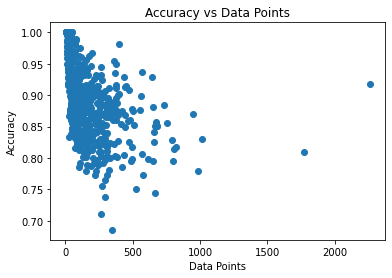

In [ ]:
correlationDict = {}
xValuesNumberPointsData = []
yValuesAccuracyGuess = []
a = "ATGC"
for eachMotif in itertools.product(a, repeat = 5):
    currentMotif = ''.join(eachMotif)
    correlationDict[currentMotif] = []
    for motifDictionaries in accuracyCategoryDict.values():
        if motifDictionaries[currentMotif] >= 0:
            correlationDict[currentMotif].append(motifDictionaries[currentMotif])   
    if len(correlationDict[currentMotif]) > 0:
        xValuesNumberPointsData.append(motifDataDictionary.get(currentMotif))
        yValuesAccuracyGuess.append(mean(correlationDict[currentMotif]))

plt.scatter(xValuesNumberPointsData, yValuesAccuracyGuess)
plt.title("Accuracy vs Data Points")
plt.xlabel("Data Points")
plt.ylabel("Accuracy")
plt.show()


In [ ]:
completeCategoryDict = UpdatedKmerPredictionAccuracyDBSCAN3(dfDirect, dfIVT, categories)
nonNegCompleteAccuracies = [val for val in completeCategoryDict.values() if val >= 0]
print(str(mean(nonNegCompleteAccuracies)))

1.0


- New Classification Method
- Semi-supervised model
- Plot samples vs accuracy